# Eval code

In [10]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import pandas as pd

# Load the TensorBoard event file
event_path = r"runs\ALE\SpaceInvaders-v5__ppo_clean_rl__1__20241222_113601\events.out.tfevents.1734863766.DESKTOP-O5Q6R7F.17768.0"
event_acc = EventAccumulator(event_path)
event_acc.Reload()

# Get list of available tags/metrics
tags = event_acc.Tags()

# Create dictionary to store metrics
metrics = {}

# Extract metrics into dictionary
for tag in tags['scalars']:
    events = event_acc.Scalars(tag)
    metrics[tag] = pd.DataFrame(events)[['step', 'value']]
    metrics[tag] = metrics[tag].set_index('step')
    metrics[tag].columns = [tag]

# Combine all metrics into single dataframe by joining on step index
df = pd.DataFrame()
for metric_df in metrics.values():
    df = df.join(metric_df, how='outer')

print(f"df.shape: {df.shape}")
df.head(10)

df.shape: (100, 3)


,eval/episodic_return,eval/episodic_length,eval/episodic_time
step,,,
0,500.0,885.0,1.696431
1,485.0,944.0,1.517179
2,270.0,744.0,1.085669
3,375.0,811.0,1.146262
4,400.0,792.0,1.103187
5,275.0,645.0,0.951736
6,365.0,722.0,1.114528
7,240.0,508.0,0.777512
8,575.0,1181.0,1.911992


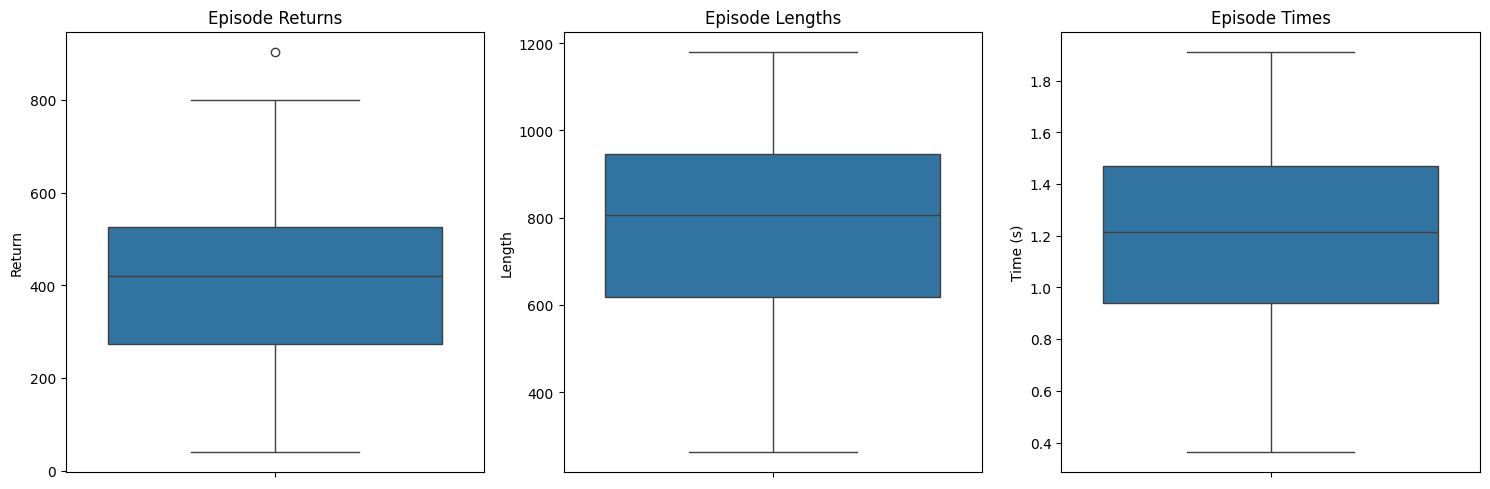

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Create box plots for each metric
sns.boxplot(y=df['eval/episodic_return'].dropna(), ax=axes[0])
axes[0].set_title('Episode Returns')
axes[0].set_ylabel('Return')

sns.boxplot(y=df['eval/episodic_length'].dropna(), ax=axes[1]) 
axes[1].set_title('Episode Lengths')
axes[1].set_ylabel('Length')

sns.boxplot(y=df['eval/episodic_time'].dropna(), ax=axes[2])
axes[2].set_title('Episode Times')
axes[2].set_ylabel('Time (s)')

plt.tight_layout()
plt.show()


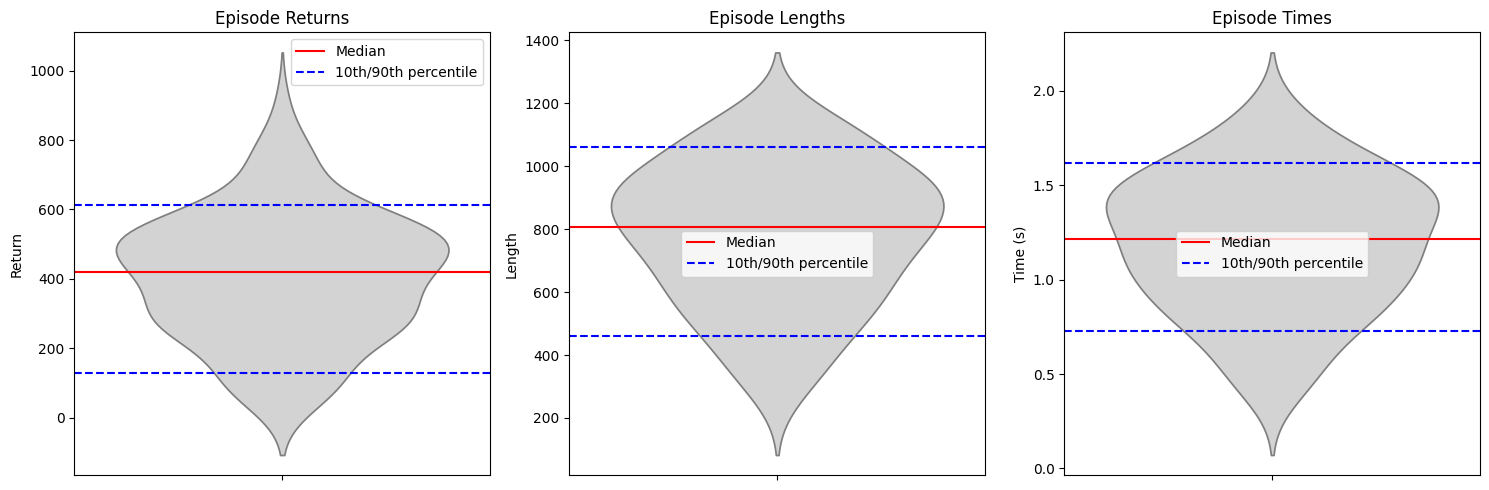

In [14]:
# Create figure with subplots for median/percentile plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Calculate percentiles for each metric
metrics = ['eval/episodic_return', 'eval/episodic_length', 'eval/episodic_time']
titles = ['Episode Returns', 'Episode Lengths', 'Episode Times'] 
ylabels = ['Return', 'Length', 'Time (s)']

for i, (metric, title, ylabel) in enumerate(zip(metrics, titles, ylabels)):
    data = df[metric].dropna()
    
    # Calculate statistics
    median = np.median(data)
    p10 = np.percentile(data, 10)
    p90 = np.percentile(data, 90)
    
    # Create violin plot
    sns.violinplot(y=data, ax=axes[i], inner=None, color='lightgray')
    
    # Add lines for median and percentiles
    axes[i].axhline(y=median, color='red', linestyle='-', label='Median')
    axes[i].axhline(y=p10, color='blue', linestyle='--', label='10th/90th percentile')
    axes[i].axhline(y=p90, color='blue', linestyle='--')
    
    axes[i].set_title(title)
    axes[i].set_ylabel(ylabel)
    axes[i].legend()

plt.tight_layout()
plt.show()


# Train

In [17]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import pandas as pd

# Load the TensorBoard event file
event_path = r"runs\ALE\SpaceInvaders-v5__ppo_clean_rl__1__20241222_024828\events.out.tfevents.1734832114.DESKTOP-O5Q6R7F.19192.0"
event_acc = EventAccumulator(event_path)
event_acc.Reload()

# Get list of available tags/metrics
tags = event_acc.Tags()

# Create dictionary to store metrics
metrics = {}

# Extract metrics into dictionary
for tag in tags['scalars']:
    events = event_acc.Scalars(tag)
    metrics[tag] = pd.DataFrame(events)[['step', 'value']]
    metrics[tag] = metrics[tag].set_index('step')
    metrics[tag].columns = [tag]

# Combine all metrics into single dataframe by joining on step index
df = pd.DataFrame()
for metric_df in metrics.values():
    df = df.join(metric_df, how='outer')

# Rename training metrics to have train/ prefix
rename_map = {
    'charts/episodic_return': 'train/episodic_return',
    'charts/episodic_length': 'train/episodic_length', 
    'charts/episodic_time': 'train/episodic_time'
}

df = df.rename(columns=rename_map)

# Select only training metrics
cols = ['train/episodic_return', 'train/episodic_length', 'train/episodic_time']
df = df[cols]


print(f"df.shape: {df.shape}")
df.head(10)

df.shape: (1223, 3)


,train/episodic_return,train/episodic_length,train/episodic_time
step,,,
816,50.0,255.0,4.035761
1040,60.0,287.0,17.487593
1072,110.0,291.0,18.004307
1120,70.0,327.0,18.295189
1392,45.0,389.0,18.136248
1760,110.0,468.0,19.850986
1808,80.0,504.0,20.833427
1840,140.0,511.0,20.118240
1888,200.0,513.0,21.445322


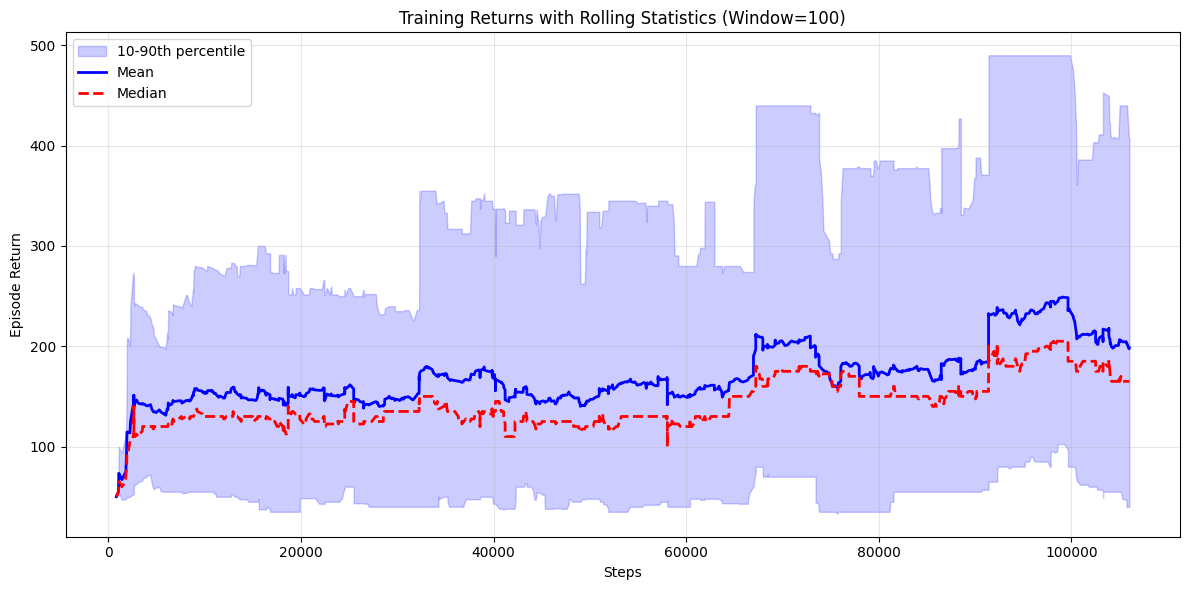

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate rolling statistics with window of 100
window = 100
rolling_mean = df['train/episodic_return'].rolling(window=window, min_periods=1).mean()
rolling_median = df['train/episodic_return'].rolling(window=window, min_periods=1).median()
rolling_10th = df['train/episodic_return'].rolling(window=window, min_periods=1).quantile(0.1)
rolling_90th = df['train/episodic_return'].rolling(window=window, min_periods=1).quantile(0.9)

# Create the plot
plt.figure(figsize=(12,6))

# Plot the shaded area between 10th and 90th percentiles
plt.fill_between(df.index, rolling_10th, rolling_90th, alpha=0.2, color='blue', label='10-90th percentile')

# Plot mean and median lines
plt.plot(df.index, rolling_mean, 'b-', label='Mean', linewidth=2)
plt.plot(df.index, rolling_median, 'r--', label='Median', linewidth=2)

plt.title('Training Returns with Rolling Statistics (Window=100)')
plt.xlabel('Steps')
plt.ylabel('Episode Return')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


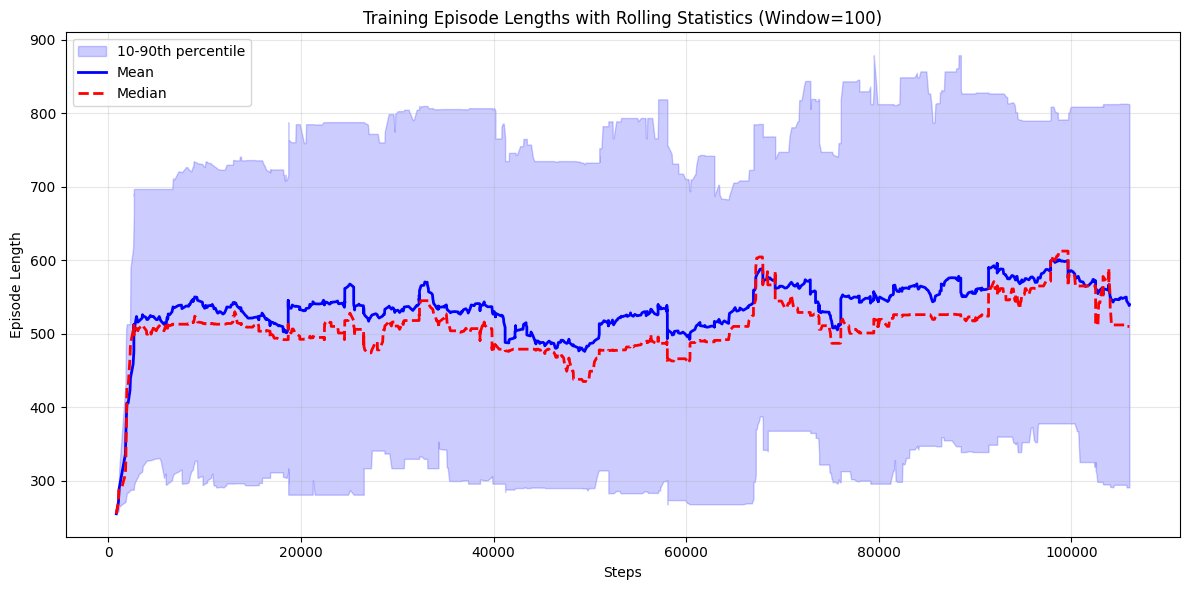

In [23]:
# Calculate rolling statistics with window of 100 for episode length
window = 100
rolling_mean = df['train/episodic_length'].rolling(window=window, min_periods=1).mean()
rolling_median = df['train/episodic_length'].rolling(window=window, min_periods=1).median()
rolling_10th = df['train/episodic_length'].rolling(window=window, min_periods=1).quantile(0.1)
rolling_90th = df['train/episodic_length'].rolling(window=window, min_periods=1).quantile(0.9)

# Create the plot
plt.figure(figsize=(12,6))

# Plot the shaded area between 10th and 90th percentiles
plt.fill_between(df.index, rolling_10th, rolling_90th, alpha=0.2, color='blue', label='10-90th percentile')

# Plot mean and median lines
plt.plot(df.index, rolling_mean, 'b-', label='Mean', linewidth=2)
plt.plot(df.index, rolling_median, 'r--', label='Median', linewidth=2)

plt.title('Training Episode Lengths with Rolling Statistics (Window=100)')
plt.xlabel('Steps')
plt.ylabel('Episode Length')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
